In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1007%2F1814%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T072051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51c6a7ff44df26658b22c64888a4ac78f36ea0707ce1480e4fa0dadbbfb7403ebfeb7f6a7a1c4bac7edb46379280358588c26531e2a6344d0a7d879e69bbd916884762157cb91406aee9a357bd13ca76c9ff8c253aa759364f64621597744274bec6aed3fc3892e73b6154251afee88a5c92319fd2c27a1e6e4cbf0c8f1299a76af90c4a1d4a9beef0d0dd8b2fa6f8854be86f454912bdf83be2c07ad1c81a2507ede06df5010d895244a32bad34854357c2bd3117df847498e5f756856f8633faaf33539f52fde402ae668280b09e30d8d682c2197ad7f28c28fc81346964d95eef138a49396e7cd80b8373f1767f8a7165cbf9bfa17abeb97fa9c446cb2aac,sandp500:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1908%2F17155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T072051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c5f2e9db70797137cb5dacd1635db5a2bc51c77974a32e4957772a57e52e69300171f6a9fb59a22bb1e16f4140f1e26ae5272a634b9e525ebc15c1d48342ade0d9df22cf9aa189e18db0448847fc6cca7a60fb259863e38e74f84c4b7248348e1b855b73e18fdb3b6e8f5d3da23a8e0dc36d3e59b83d00f8bca040c3f6cacb6562e2145d236e4a7aebbac42e1a77b7404e10369f969ce124a87f2bf8b713bd51e767218573bba32a674e8c6037620f162effc2e30398ff515c680586c54c85b3e59c8719badfbc2e55c71093d395ae8334cf13dd5a9f52f4d230dc9262f9029b9197ee3473032b4580b6bdba5867a12fe25959c422ec315add763ea1700d58d,amzn-dpz-btc-ntfx-adjusted-may-2013may2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F195545%2F433077%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T072052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D684647b7e6c0e8d031a3ad95a143849d1a52e12f62a7ee94d83fc6fcdfcf459b49c2073e88ddee4f57d848ed1a25e5d35c42438a9badf55d5c8ec63a2982939963ea1f84222cef19d1b98d2e502af439e36d79dba2019ee628e9cfc30a64bb96d1d40a167d7651e01c7222365bac011b077943f2d891eaa2037081e28989d26ef629f89bca7c686b9c37e86ebd2a5d05629d0898d9ca6dc657939377fbd0fed144388f36d70a02bfe66df88766dd8cfda13d0d00fdcf75dc08e283717e9b447afa6ed20278b5ad0a0567b8b42a6a231dc36106f1ab43a18419c12ba08fd2347a8d844b8d49a100b6665ded12f6e2290020cf7775b32b970cb5695a45aa847877,apple-aapl-historical-stock-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F533900%2F976925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T072052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44a41b8e0756fcf3ea7334568794883f46c517d93be20d16f138acdc792f068a579d48e19d17b1e010dbfc27efadd91535c546865dfc68153428af6ac6611e6524dc8dee182b7617a822b9331b06da281324d9abefcfdcd8692b9b5793a6234c331599a538d703ce4495322114b5201d024de2c006e484e56fd2af94679779c49de1c8d24f363d345cc41c1b2fdd2384019c54cd50229b69f5e801e6448ff4b31579843b1439562000b379e6c063a3c402d185c99edf2b63b1581a51940f4a19d8311eda8e9f098c304b47801aa016ccc1ec97995949012a08eb9e5f749a2165456fe78c1dad69177dbf9cdb83fcc24410afe1922c0a811c354d418687cb63dd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34499 bytes downloaded
Downloaded and uncompressed: tesla-stock-price
[==================================================] 20283917 bytes downloaded
Downloaded and uncompressed: sandp500
[==================================================] 30437 bytes downloaded
Downloaded and uncompressed: amzn-dpz-btc-ntfx-adjusted-may-2013may2019
[==================================================] 50651 bytes downloaded
Downloaded and uncompressed: apple-aapl-historical-stock-data
Data source import complete.


In [2]:
!pip install -q yfinance

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-03-15,176.639999,177.929993,173.899994,174.419998,174.419998,72115500,AMAZON
2024-03-18,175.800003,176.690002,174.279999,174.479996,174.479996,31250700,AMAZON
2024-03-19,174.220001,176.089996,173.520004,175.899994,175.899994,26880900,AMAZON
2024-03-20,176.139999,178.529999,174.639999,178.149994,178.149994,29947200,AMAZON
2024-03-21,179.990005,181.419998,178.149994,178.149994,178.149994,32824300,AMAZON
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100,AMAZON
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29815500,AMAZON
2024-03-26,180.149994,180.449997,177.949997,178.300003,178.300003,29659000,AMAZON
2024-03-27,179.880005,180.000000,177.309998,179.830002,179.830002,33272600,AMAZON


In [4]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,249.000000,249.000000,249.000000,249.000000,249.000000,2.490000e+02
mean,180.897832,182.350161,179.553895,181.047109,180.589378,5.748903e+07
std,9.276276,9.139226,9.213128,9.156795,9.225381,1.727822e+07
min,161.220001,162.029999,159.779999,160.100006,159.250000,2.404830e+07
25%,173.160004,174.589996,172.050003,173.660004,173.229996,4.679290e+07
50%,180.869995,182.339996,178.970001,180.750000,180.242249,5.363130e+07
75%,189.330002,189.990005,187.779999,189.369995,188.969589,6.230330e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [5]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2023-04-03 to 2024-03-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          249 non-null    float64
 1   High          249 non-null    float64
 2   Low           249 non-null    float64
 3   Close         249 non-null    float64
 4   Adj Close     249 non-null    float64
 5   Volume        249 non-null    int64  
 6   company_name  249 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.6+ KB


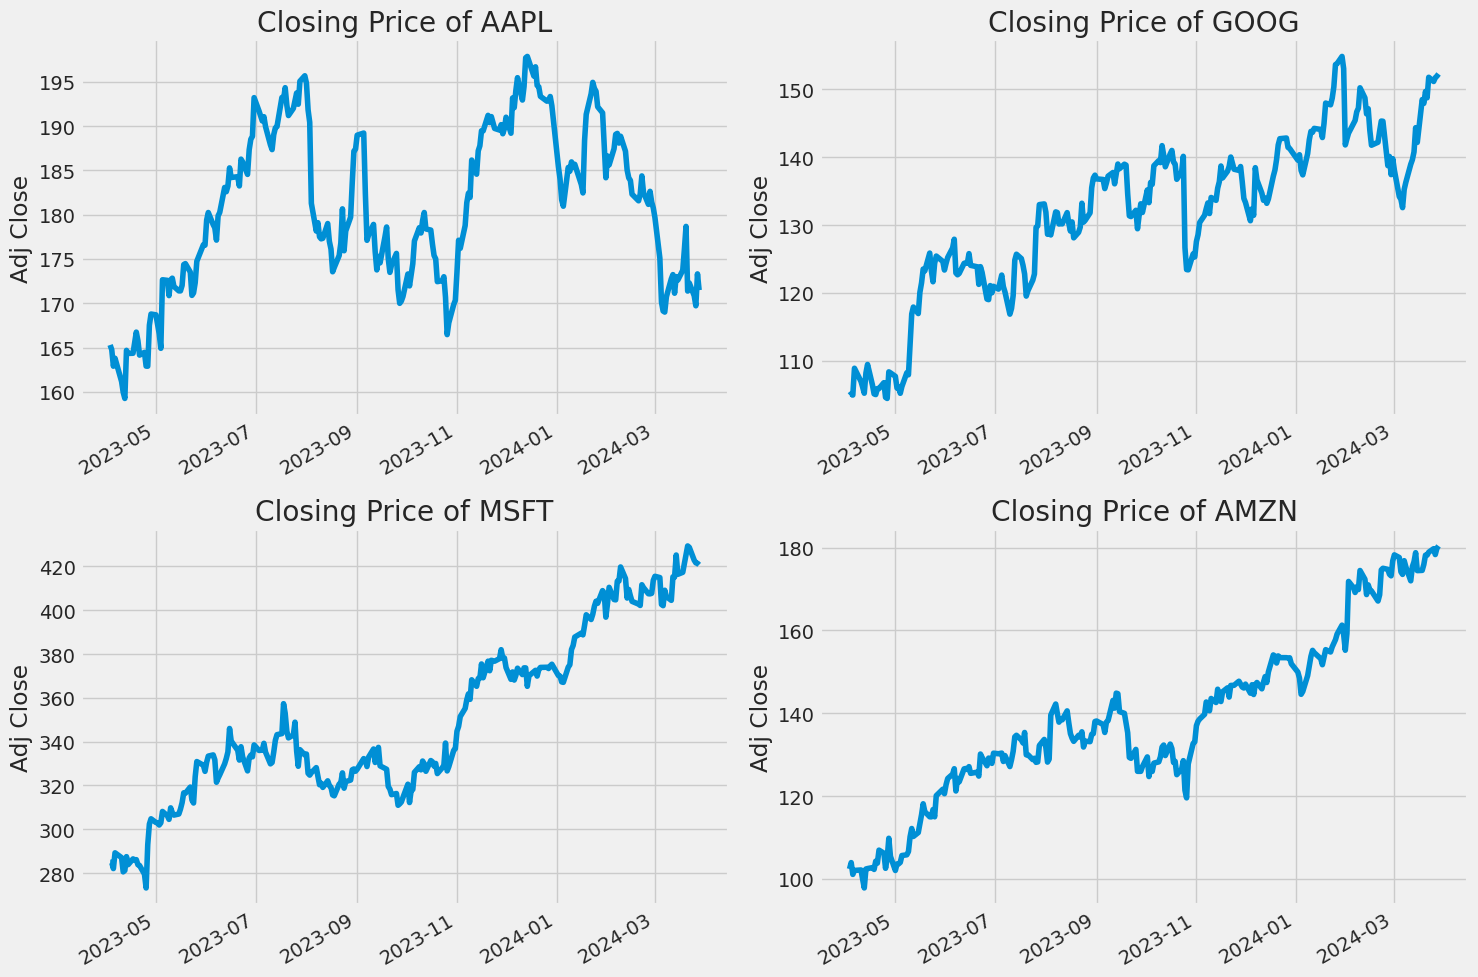

In [6]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

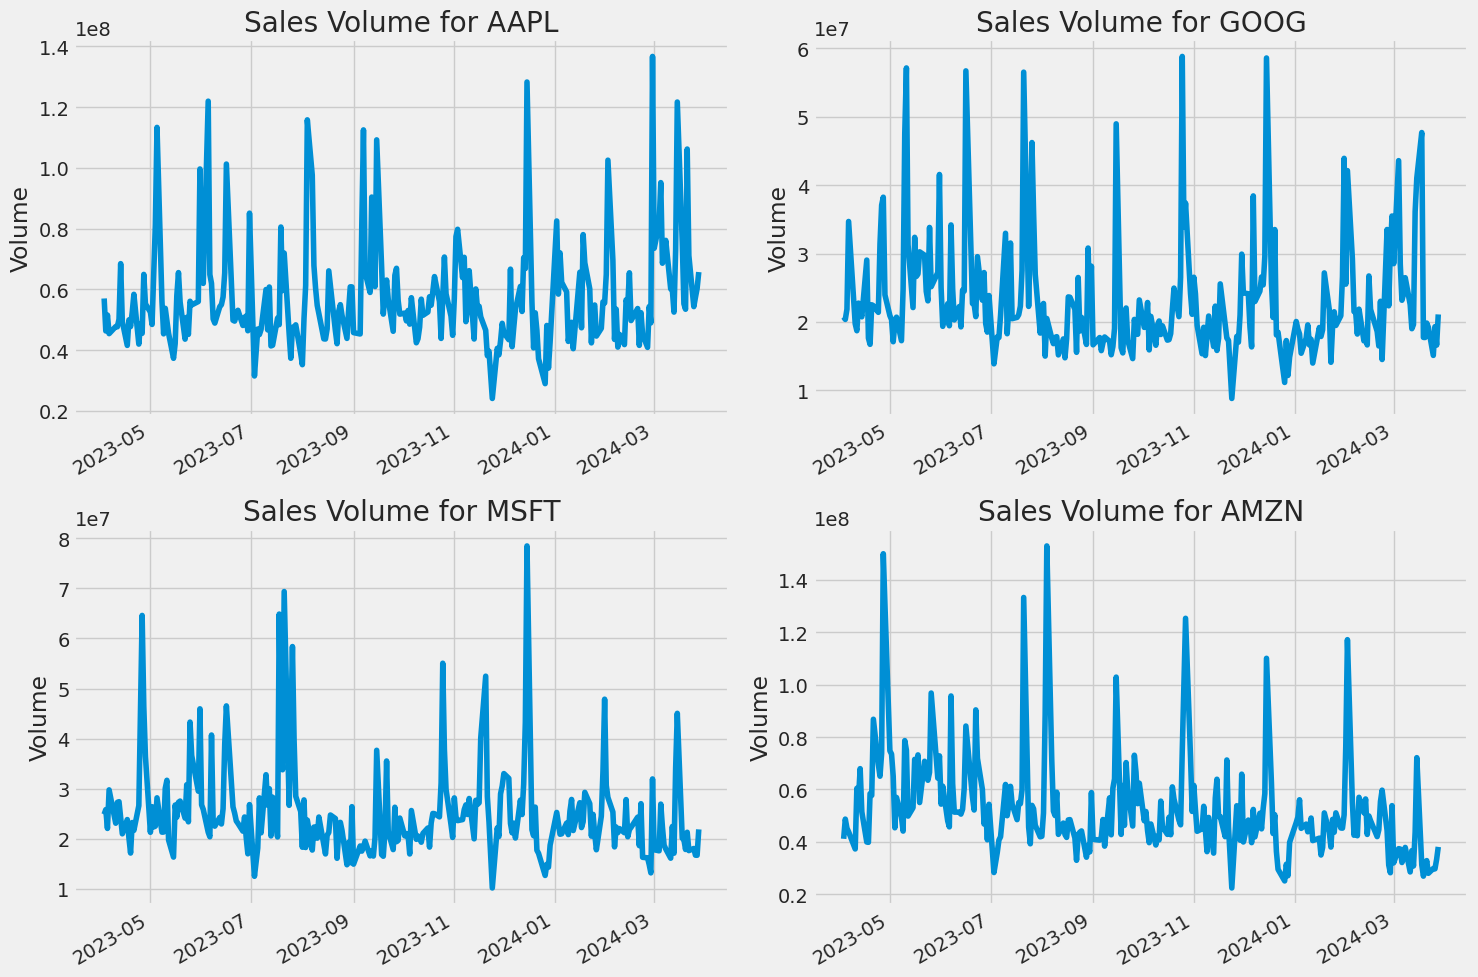

In [7]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

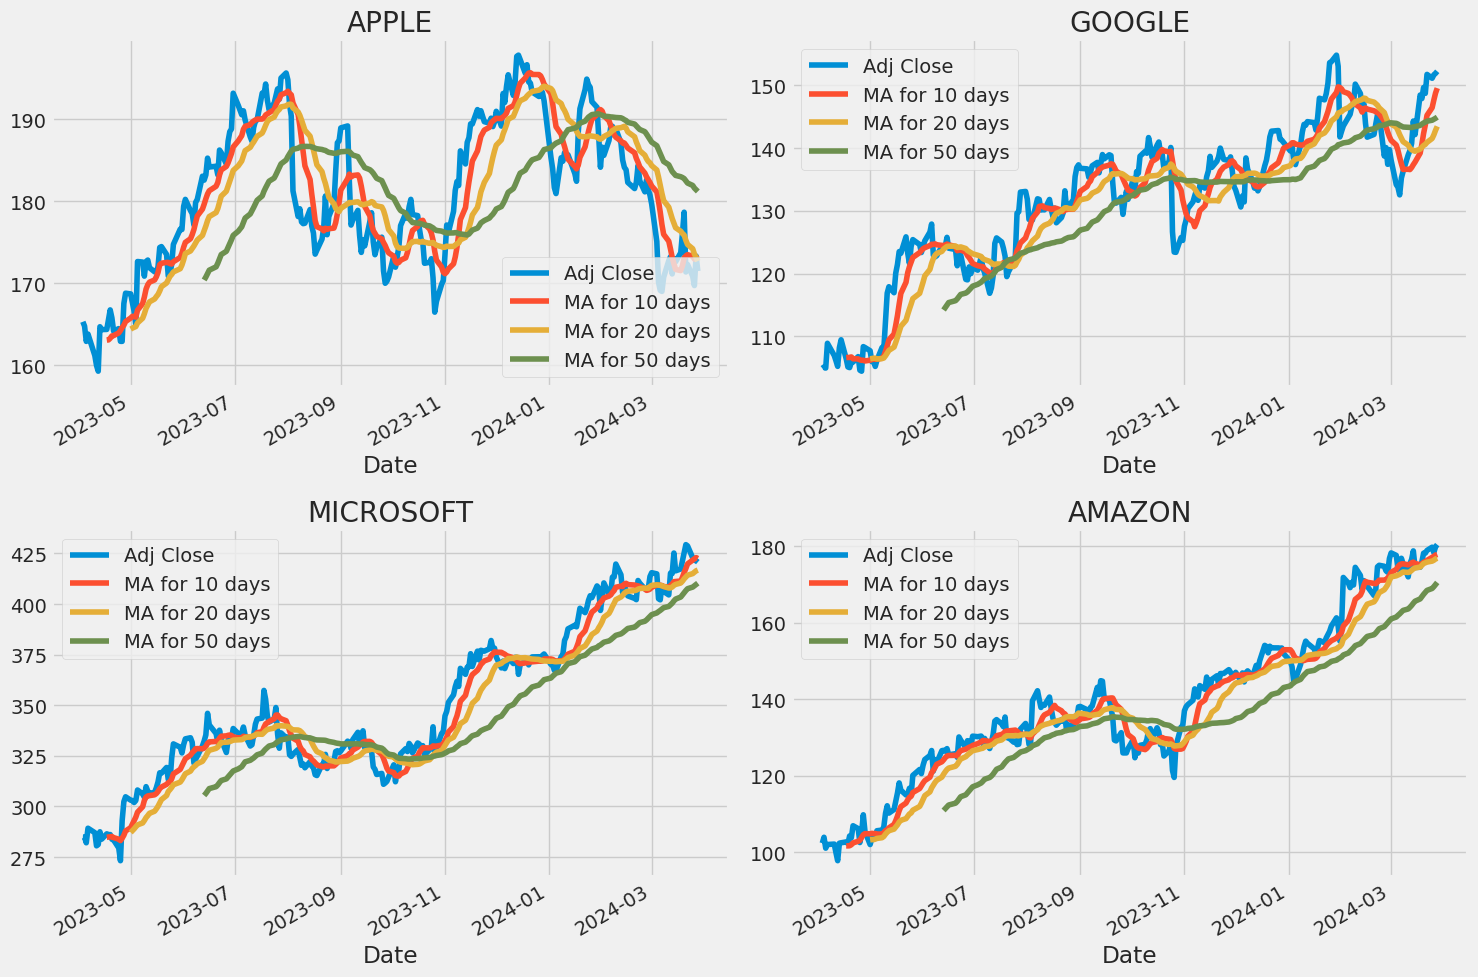

In [8]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

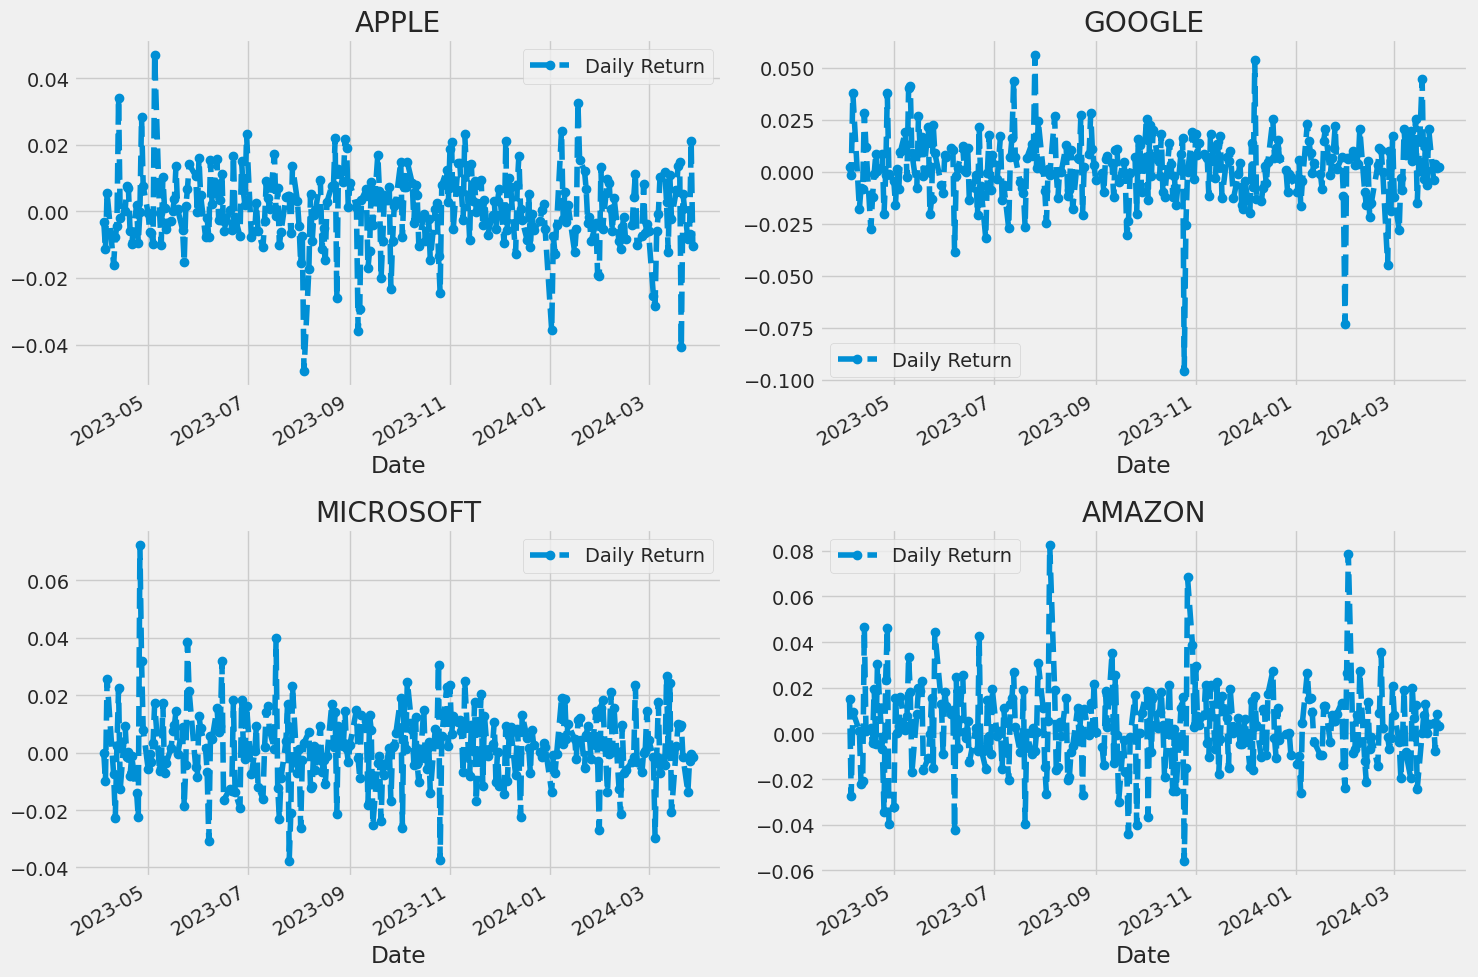

In [9]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

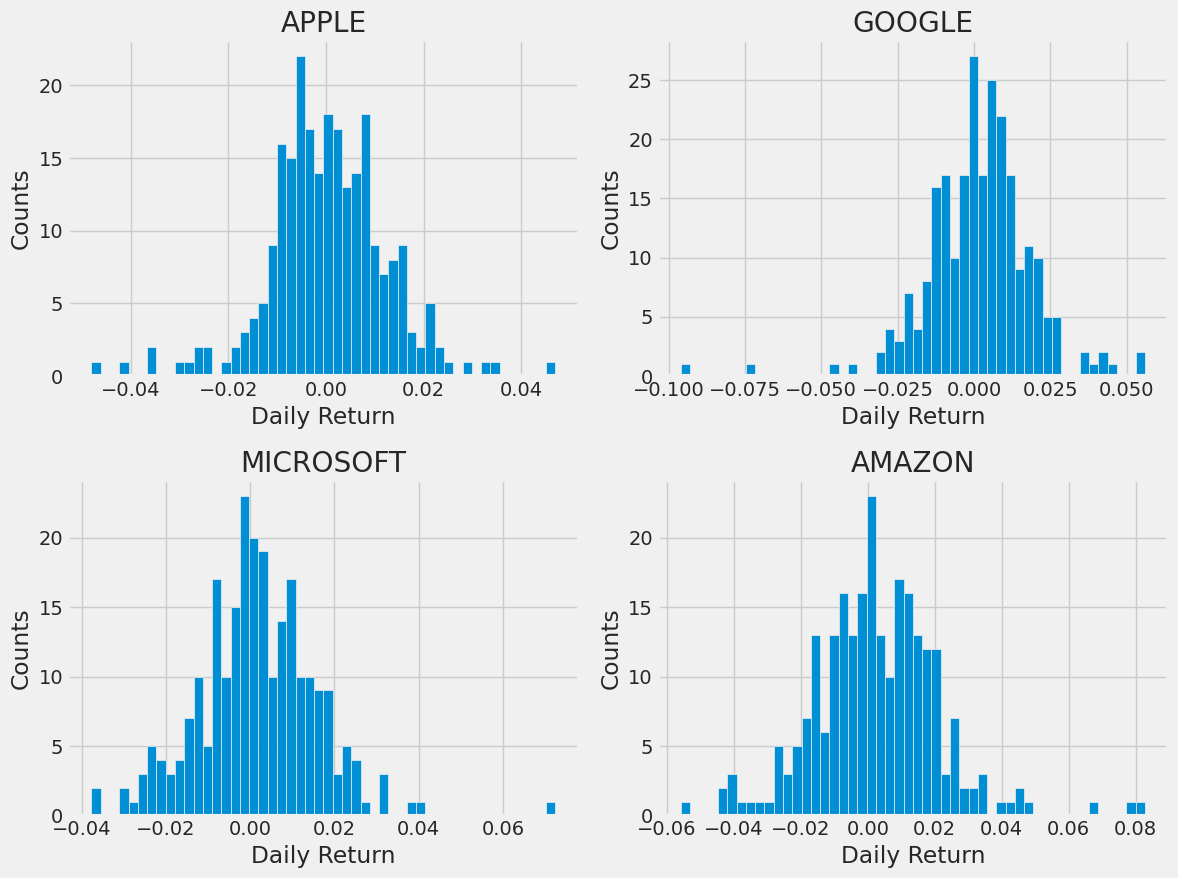

In [10]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

In [11]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-04-03,NaN,NaN,NaN,NaN
2023-04-04,-0.003250,0.015038,0.002002,-0.000174
2023-04-05,-0.011290,-0.027417,-0.001617,-0.009889
2023-04-06,0.005496,0.009496,0.037637,0.025533
2023-04-10,-0.015972,0.001078,-0.017906,-0.007579


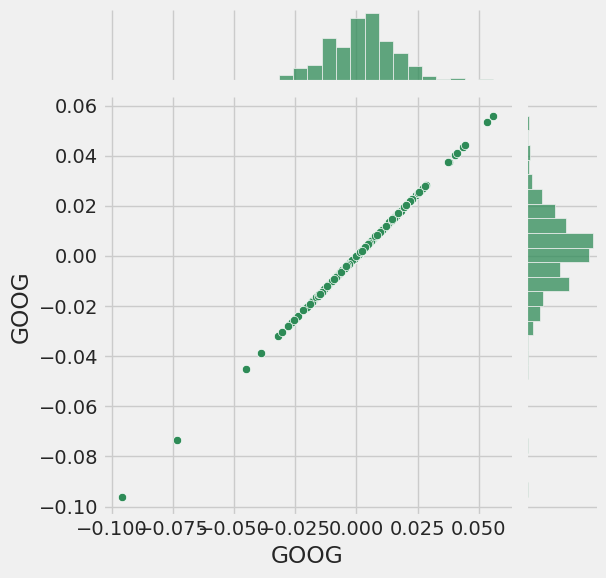

In [12]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

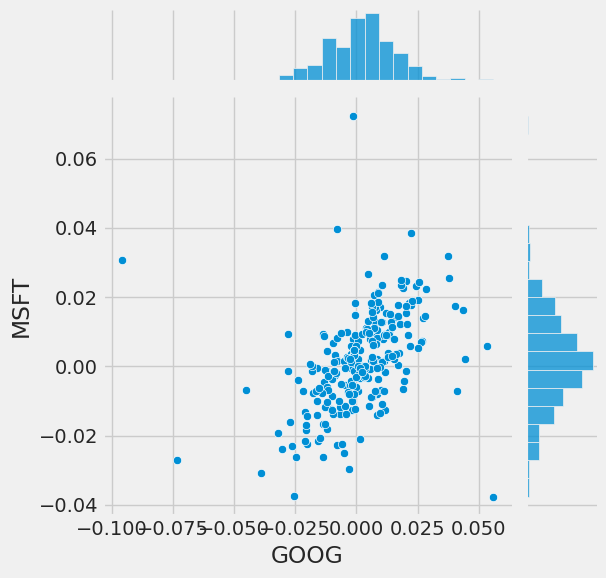

In [13]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

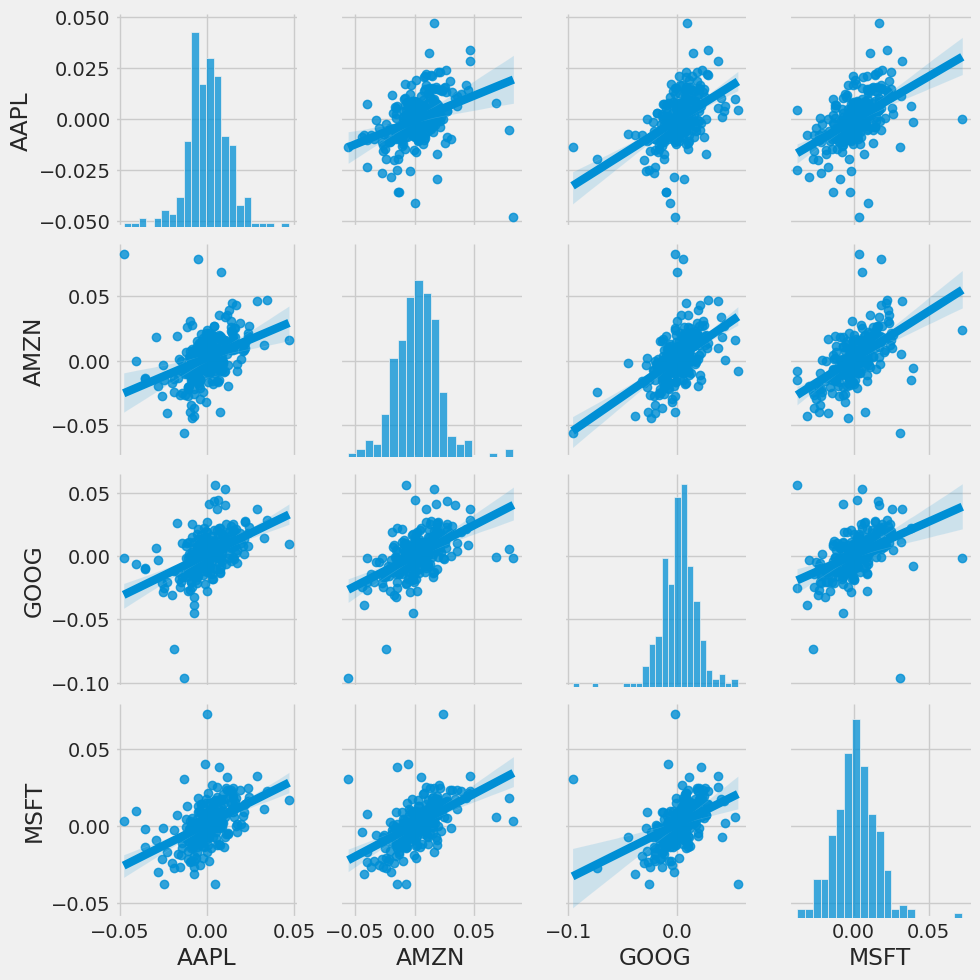

In [14]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

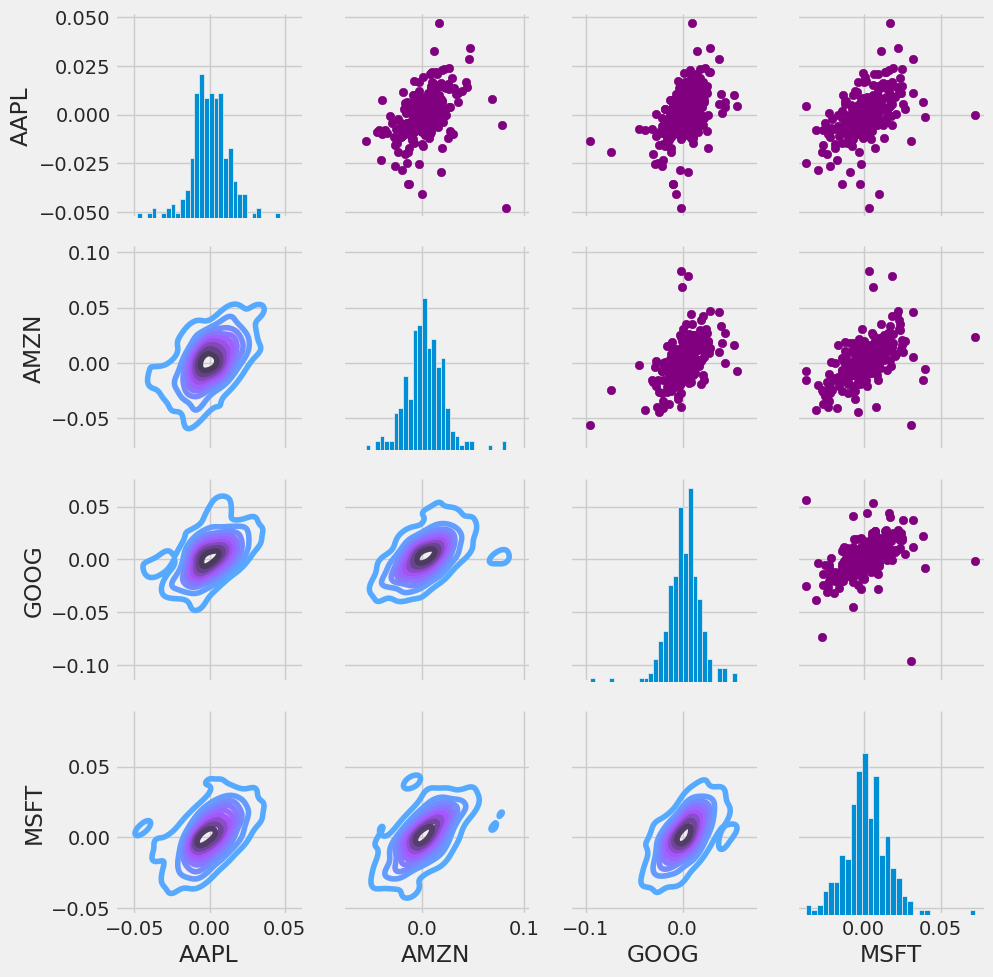

In [15]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

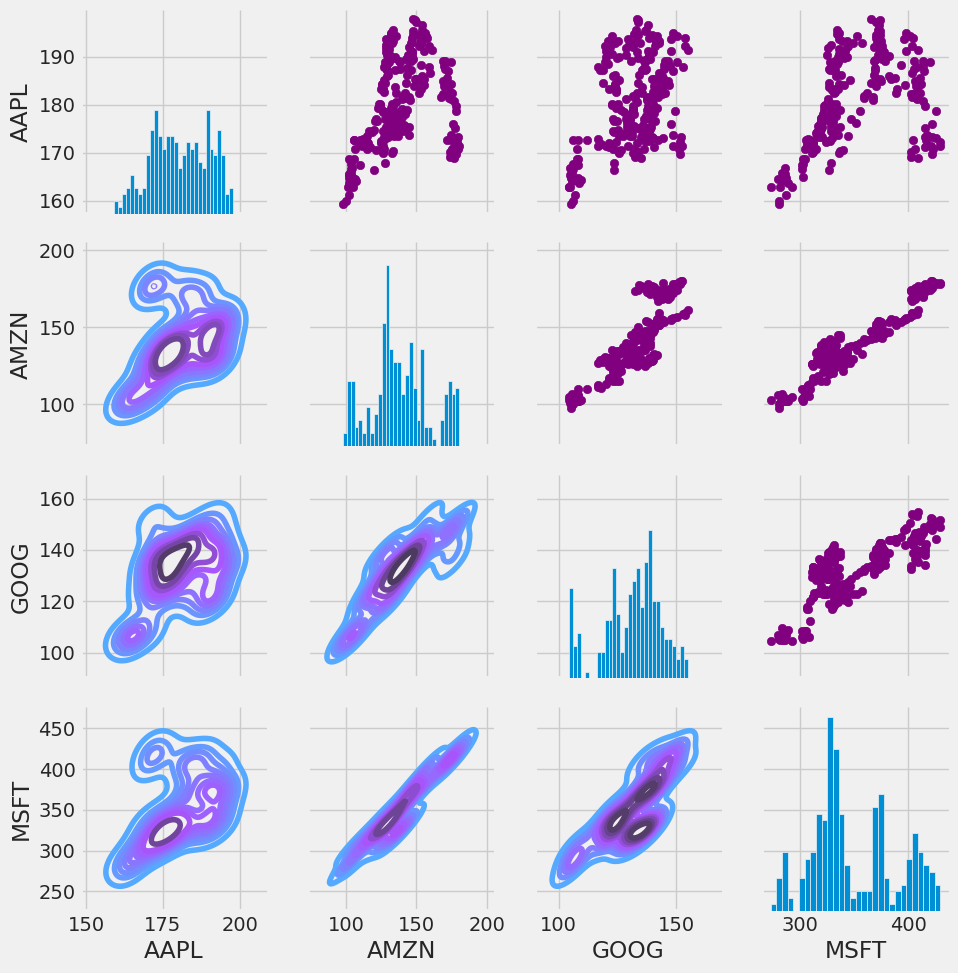

In [16]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

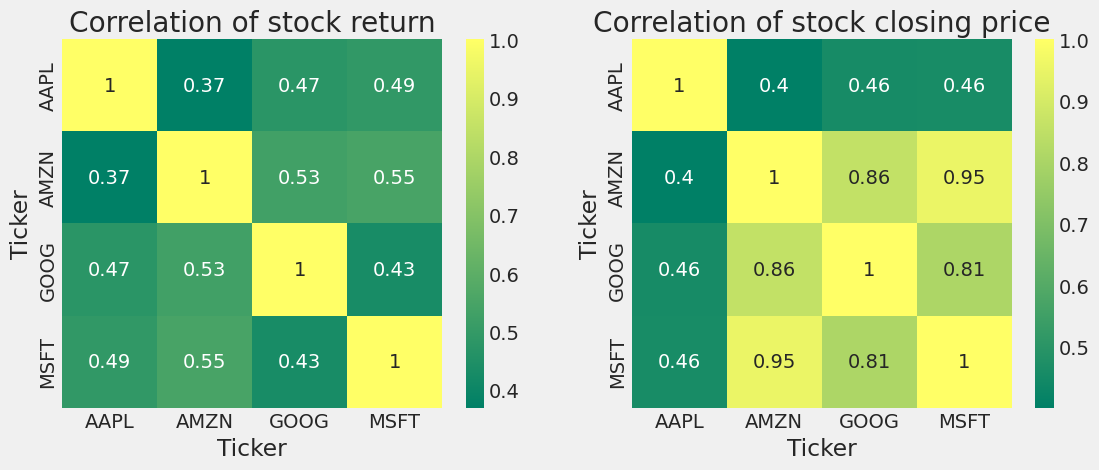

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

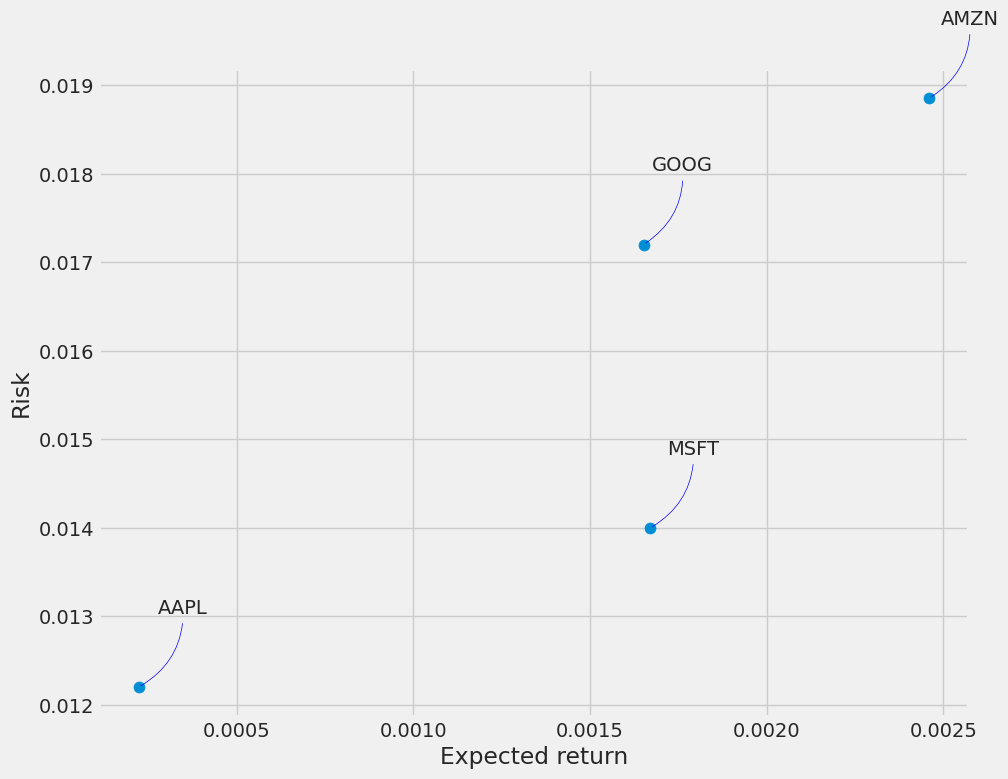

In [18]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [19]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433827,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771557,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751297,394024400
...,...,...,...,...,...,...
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400


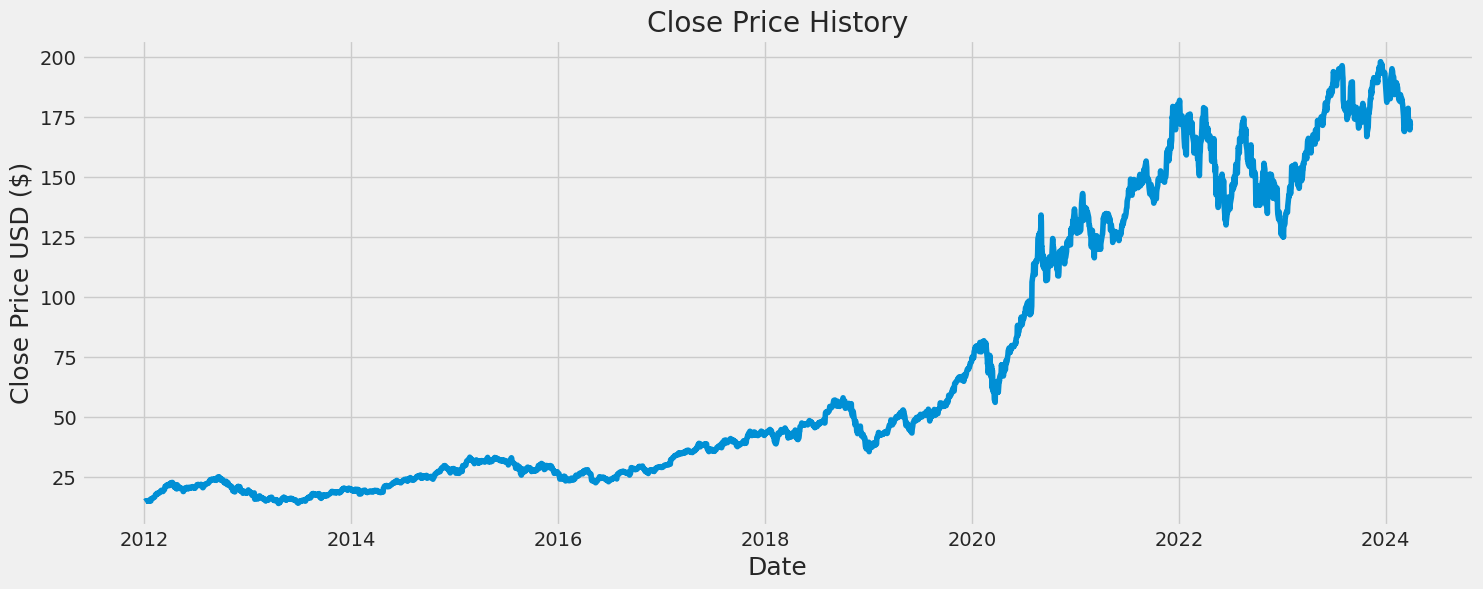

In [20]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [21]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2926

In [22]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.8457884 ],
       [0.8653363 ],
       [0.85539942]])

In [23]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2866/2866 [==============================] - 180s 61ms/step - loss: 9.3140e-04


In [25]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 37ms/step


5.006078761417753

<ipython-input-26-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


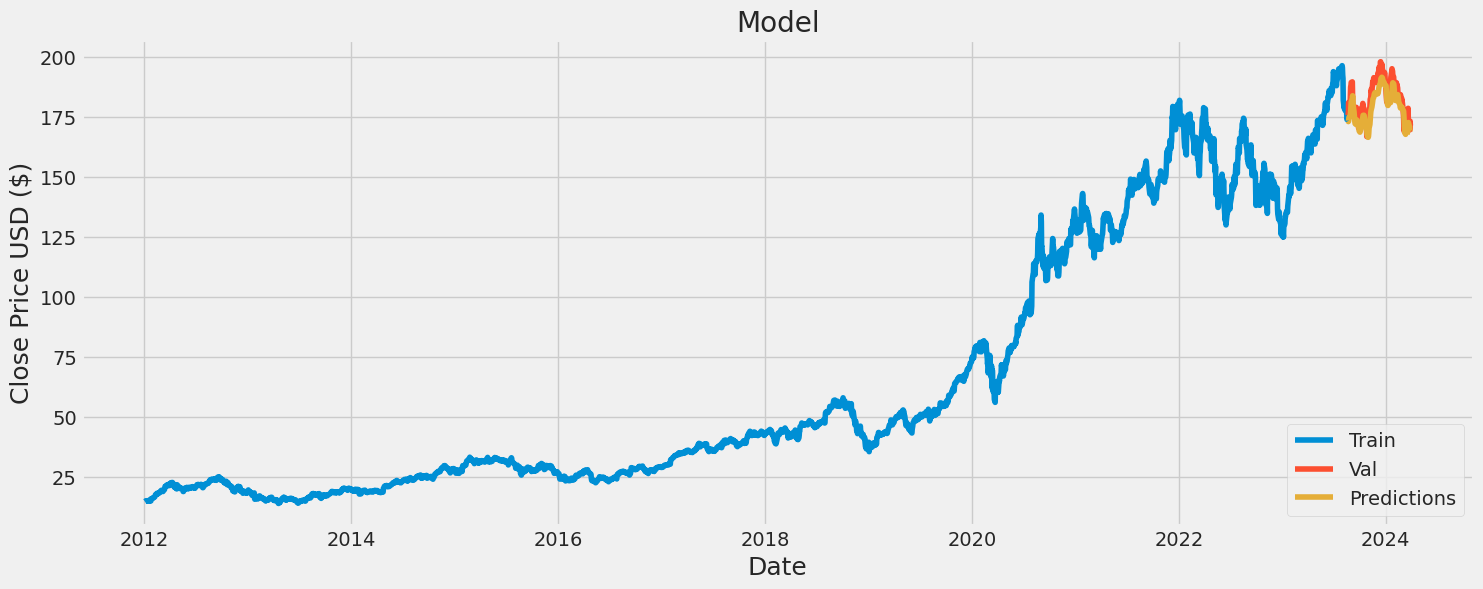

In [26]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-08-21,175.839996,173.345062
2023-08-22,177.229996,173.123322
2023-08-23,181.119995,173.468399
2023-08-24,176.380005,174.866104
2023-08-25,178.610001,174.986084
...,...,...
2024-03-22,172.279999,172.066223
2024-03-25,170.850006,171.126480
2024-03-26,169.710007,169.927414
